# Multimodal audio+image pipeline

This notebook contains a reorganized, split version of the original monolithic pipeline.
Cells are grouped by purpose (settings, extraction, audio cleaning, dataset, model, training, tests).
Keep this structure for easier refactoring, commenting and testing.

In [31]:
# Libraries

import os, glob, subprocess, math
import numpy as np
from PIL import Image
import soundfile as sf

from tqdm import tqdm

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as AF

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

from torch.utils.data import DataLoader, Subset
import torch
import math
import random



In [32]:
# SETTINGS
RAW_VIDEOS   = "D:/Downloads/audio/full clips"     # input videos
AUDIO_DIR    = "D:/Downloads/audio/aud"   # output 2s wavs
IMAGE_DIR    = "D:/Downloads/audio/img"  # output frame jpgs


SAMPLE_RATE  = 48000
CHUNK_SECONDS= 2
N_MELS       = 64
BATCH_SIZE   = 20
EPOCHS       = 7
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
# Print device info to confirm CUDA availability and details
print('Torch CUDA available:', torch.cuda.is_available())
print('Using device:', DEVICE)
if torch.cuda.is_available():
    try:
        print('CUDA device count:', torch.cuda.device_count())
        if torch.cuda.device_count() > 0:
            try:
                cur = torch.cuda.current_device()
                print('CUDA current device index:', cur)
                print('CUDA device name:', torch.cuda.get_device_name(cur))
            except Exception as e:
                print('Could not query CUDA device name:', e)
    except Exception as e:
        print('CUDA query error:', e)

label_map = {"full": 0, "half": 1, "empty": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)


Torch CUDA available: False
Using device: cpu


In [33]:
# Video -> audio/frame helpers (ffmpeg wrappers)
def extract_audio(video_path, wav_out, sample_rate=SAMPLE_RATE):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ar", str(sample_rate), "-ac", "1", wav_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def extract_frame(video_path, image_out, timestamp):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ss", f"{timestamp:.3f}", "-vframes", "1", image_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def fast_split(video_path, out_audio_dir, out_frame_dir, skip_if_exists=True):
    base = os.path.splitext(os.path.basename(video_path))[0]
    audio_pattern = os.path.join(out_audio_dir, f"{base}_seg%03d.wav")
    frame_pattern = os.path.join(out_frame_dir, f"{base}_frame%03d.jpg")

    # Simple existence check: if first segment + first frame exist, assume this video is done
    first_seg  = os.path.join(out_audio_dir, f"{base}_seg000.wav")
    first_frame = os.path.join(out_frame_dir, f"{base}_frame000.jpg")

    if skip_if_exists and os.path.exists(first_seg) and os.path.exists(first_frame):
        print(f"[SKIP] {video_path} already split.")
        return

    # Audio segments
    subprocess.run(
        [
            "ffmpeg", "-y",
            "-i", video_path,
            "-f", "segment", "-segment_time", "2",
            "-ar", "48000", "-ac", "1",
            "-c:a", "pcm_s16le",
            audio_pattern
        ],
        check=True
    )

    # Frame extraction
    subprocess.run(
        [
            "ffmpeg", "-y",
            "-i", video_path,
            "-vf", "fps=0.5",
            "-start_number", "0",
            "-qscale:v", "2",
            frame_pattern
        ],
        check=True
    )

    
    
def prepare_dataset_from_videos(raw_videos=RAW_VIDEOS):
    video_files = []
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.MOV")))
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.mov")))
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.mp4")))

    print(len(video_files))

    if not video_files:
        print(f"[WARN] No videos in {raw_videos}")
        return

    for vf in video_files:
        print("[PROCESSING]", vf)
        fast_split(vf, AUDIO_DIR, IMAGE_DIR, skip_if_exists=True)



In [34]:
# IMAGE TRANSFORM and audio cleaning constants
gray = transforms.Grayscale(num_output_channels=3)
transform_image = transforms.Compose([
    transforms.Resize((224,224)),
    gray,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Audio cleaning for a 2s chunk (band-pass + quiet-frame spectral subtraction)
SR        = SAMPLE_RATE
BAND_LO   = 12000
BAND_HI   = 18000
NFFT      = 2048
HOP       = 512
OVERSUB   = 1.2
QUIET_PCT = 0.20

def _stft(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 2: x = x.squeeze(0)
    return torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                      window=torch.hann_window(NFFT), return_complex=True, center=True)

def _istft(S: torch.Tensor, length: int) -> torch.Tensor:
    win = torch.hann_window(NFFT, device=S.device, dtype=torch.float32)
    try:
        y = torch.istft(S, n_fft=NFFT, hop_length=HOP, win_length=NFFT, window=win, length=length, center=True)
    except (TypeError, RuntimeError):
        y = torch.istft(torch.view_as_real(S), n_fft=NFFT, hop_length=HOP, win_length=NFFT, window=win, length=length, center=True)
    return y

def bandpass_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    x = waveform.squeeze(0).to(torch.float32)
    S = torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT, window=torch.hann_window(NFFT, dtype=torch.float32), return_complex=True, center=True)
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO))
    hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, S.shape[0])
    mask = torch.zeros_like(S, dtype=torch.bool)
    mask[lo:hi, :] = True
    S_bp = torch.where(mask, S, torch.zeros_like(S))
    y = _istft(S_bp, length=x.numel())
    y = y - y.mean()
    y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    return y.unsqueeze(0)

def spectral_subtract_quiet_frames(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    x = waveform.squeeze(0)
    Tlen = x.shape[-1]
    S = _stft(x)
    Mag = S.abs()
    Pow = Mag**2
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO))
    hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, Mag.shape[0])
    band_pow_per_frame = Pow[lo:hi].mean(dim=0)
    T_frames = band_pow_per_frame.numel()
    k = max(1, int(round(QUIET_PCT * T_frames)))
    vals, idxs = torch.topk(-band_pow_per_frame, k)
    quiet_mask = torch.zeros_like(band_pow_per_frame, dtype=torch.bool)
    quiet_mask[idxs] = True
    Npsd = Pow[:, quiet_mask].mean(dim=1, keepdim=True)
    Pclean = torch.clamp(Pow - OVERSUB * Npsd, min=0.0)
    Mag_clean = torch.sqrt(Pclean + 1e-12)
    S_clean = Mag_clean * torch.exp(1j * S.angle())
    y_clean = _istft(S_clean, length=Tlen)
    y_clean = y_clean - y_clean.mean()
    y_clean = torch.nan_to_num(y_clean, nan=0.0, posinf=0.0, neginf=0.0)
    return y_clean.unsqueeze(0)

def clean_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    if waveform.dim() == 2 and waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    elif waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    if sr != SR:
        waveform = torchaudio.functional.resample(waveform, sr, SR)
        sr = SR
    y_bp = bandpass_chunk(waveform, sr)
    y_cl = spectral_subtract_quiet_frames(y_bp, sr)
    return y_cl


In [35]:
# DATASET
class AudioImageDataset(Dataset):
    def __init__(self, audio_dir, image_dir, label_map,
                 transform_image=None,
                 sample_rate=SAMPLE_RATE,
                 n_mels=N_MELS,
                 use_filters=True):
        self.audio_dir = audio_dir
        self.image_dir = image_dir
        self.label_map = label_map
        self.transform_image = transform_image
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.use_filters = use_filters

        self.audio_files, self.labels, self.video_ids = [], [], []

        # Match audio segments to frames and labels
        for file in os.listdir(audio_dir):
            if file.endswith(".wav") and "_seg" in file:
                frame_file = file.replace("seg", "frame").replace(".wav", ".jpg")
                if not os.path.exists(os.path.join(image_dir, frame_file)):
                    continue

                base_name = file.split("_seg")[0]
                label_str = base_name.split("_")[0].lower()

                if label_str in label_map:
                    self.audio_files.append(file)
                    self.labels.append(label_map[label_str])
                    self.video_ids.append(file)

        # Mel + dB transforms (these are fine to keep from torchaudio)
        self.mel = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=self.n_mels,
        )
        self.db  = T.AmplitudeToDB()

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label      = self.labels[idx]
        seg_id     = self.video_ids[idx]

        # ------- AUDIO LOADING (no torchaudio.load) -------
        a_path = os.path.join(self.audio_dir, audio_file)

        # soundfile returns numpy array (T,) or (T, C)
        audio_np, sr = sf.read(a_path, dtype="float32")

        # Make shape (C, T) to mimic torchaudio.load
        if audio_np.ndim == 1:
            audio_np = audio_np[None, :]          # (1, T)
        else:
            audio_np = audio_np.T                 # (C, T)

        waveform = torch.from_numpy(audio_np)     # (C, T) float32

        # Optional cleaning / resampling
        if self.use_filters:
            waveform = clean_chunk(waveform, sr)
        else:
            if sr != self.sample_rate:
                waveform = torchaudio.functional.resample(
                    waveform, sr, self.sample_rate
                )

        # ------- MEL SPECTROGRAM -------
        spec = self.mel(waveform)   # (C, n_mels, time)
        spec = self.db(spec)

        # Normalize
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)

        # Resize to 224x224 and collapse channels
        # spec: (C, n_mels, time) -> (1, C, H, W) -> (1, 224, 224)
        spec = F.interpolate(
            spec.unsqueeze(0),
            size=(224, 224),
            mode="bilinear",
            align_corners=False,
        )
        spec = spec.mean(dim=1)     # (1, 224, 224)  – single-channel “image”

        # ------- IMAGE LOADING -------
        frame_file = audio_file.replace("seg", "frame").replace(".wav", ".jpg")
        img_path = os.path.join(self.image_dir, frame_file)
        img = Image.open(img_path).convert("RGB")

        if self.transform_image:
            img = self.transform_image(img)

        return spec, img, label, seg_id


In [36]:
def create_loaders(
    dataset,
    batch_size,
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    seed=42,
):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6, "Fractions must sum to 1.0"

    n = len(dataset)
    indices = list(range(n))

    random.seed(seed)
    random.shuffle(indices)

    n_train = int(n * train_frac)
    n_val   = int(n * val_frac)
    n_test  = n - n_train - n_val

    train_idx = indices[:n_train]
    val_idx   = indices[n_train:n_train + n_val]
    test_idx  = indices[n_train + n_val:]

    train_ds = Subset(dataset, train_idx)
    val_ds   = Subset(dataset, val_idx)
    test_ds  = Subset(dataset, test_idx)


    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    print(
        f"Train samples: {len(train_ds)}, "
        f"Val samples: {len(val_ds)}, "
        f"Test samples: {len(test_ds)}"
    )

    return train_loader, val_loader, test_loader


In [37]:
class MultiModalResNet(nn.Module):
    def __init__(self, num_classes=3, pretrained_image=True, pretrained_audio=True):
        super().__init__()
        self.audio_model = models.resnet18(pretrained=pretrained_audio)
        self.audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.audio_model.fc = nn.Identity()
        self.image_model = models.resnet18(pretrained=pretrained_image)
        self.image_model.fc = nn.Identity()
        self.fc = nn.Linear(512*2, num_classes)
    def forward(self, audio, image, return_features=False):
        a = self.audio_model(audio)
        i = self.image_model(image)
        fused = torch.cat([a, i], dim=1)
        out = self.fc(fused)
        if return_features:
            return a, i, fused, out
        return out


In [38]:
# FEATURE VISUALIZATION (t-SNE)
def visualize_features(model, dataloader, title_suffix=""):
    model.eval()
    audio_feats, image_feats, fused_feats, labels_all = [], [], [], []

    with torch.no_grad():
        for audio, img, labels, _ in dataloader:
            audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
            a, i, fused, _ = model(audio, img, return_features=True)
            audio_feats.append(a.cpu())
            image_feats.append(i.cpu())
            fused_feats.append(fused.cpu())
            labels_all.append(labels.cpu())

    # Handle empty loader
    if len(audio_feats) == 0:
        print("[visualize_features] No samples in dataloader – skipping t-SNE.")
        return

    audio_feats = torch.cat(audio_feats).numpy()
    image_feats = torch.cat(image_feats).numpy()
    fused_feats = torch.cat(fused_feats).numpy()
    labels_all = torch.cat(labels_all).numpy()

    print("Label counts:", Counter(labels_all))

    n = fused_feats.shape[0]
    if n < 3:
        print(f"[visualize_features] Only {n} samples – too few for t-SNE. Skipping.")
        return

    # Perplexity must be < n and generally >= 5 for stable plots
    perpl = min(30, max(5, min(n - 1, n // 3)))

    tsne = TSNE(n_components=2, random_state=42, perplexity=perpl)
    A2 = tsne.fit_transform(audio_feats)
    I2 = tsne.fit_transform(image_feats)
    F2 = tsne.fit_transform(fused_feats)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for data2d, name, ax in zip([A2, I2, F2], ["Audio", "Image", "Fused"], axes):
        for l in sorted(set(labels_all)):
            idx = labels_all == l
            ax.scatter(data2d[idx, 0], data2d[idx, 1], alpha=0.6, s=20, label=LABELS[l])
        ax.set_title(f"{name} Features {title_suffix}")
        ax.legend()

    plt.tight_layout()
    plt.show()


In [39]:

def visualize_audio_preprocessing(dataset, idx=0):
    """
    Visualize the audio preprocessing pipeline for one sample in the dataset.
    """
    audio_file = dataset.audio_files[idx]
    label      = dataset.labels[idx]
    seg_id     = dataset.video_ids[idx]

    a_path = os.path.join(dataset.audio_dir, audio_file)

    # 1) Load raw audio with soundfile
    audio_np, sr = sf.read(a_path, dtype="float32")   # (T,) or (T, C)
    if audio_np.ndim == 1:
        audio_np = audio_np[None, :]                  # (1, T)
    else:
        audio_np = audio_np.T                         # (C, T)

    waveform = torch.from_numpy(audio_np)             # (C, T)

    waveform_orig = waveform.clone()

    # 2) Optional cleaning / resampling (same as dataset)
    if dataset.use_filters:
        waveform = clean_chunk(waveform, sr)
    else:
        if sr != dataset.sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sr, dataset.sample_rate
            )
            sr = dataset.sample_rate

    waveform_after = waveform.clone()

    # 3) Mel spectrogram + dB (same modules as dataset)
    mel = dataset.mel(waveform)       # (C, n_mels, time)
    mel_db = dataset.db(mel)          # (C, n_mels, time)

    # 4) Normalize
    mel_norm = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

    # 5) Resize to 224x224 and collapse channels
    mel_resized = F.interpolate(
        mel_norm.unsqueeze(0),        # (1, C, H, W)
        size=(224, 224),
        mode="bilinear",
        align_corners=False,
    )
    mel_final = mel_resized.mean(dim=1)   # (1, 224, 224)

    # ---------- PLOTTING ----------
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    t_orig = torch.linspace(0, waveform_orig.shape[-1] / sr, waveform_orig.shape[-1])

    # Raw waveform
    axes[0, 0].plot(t_orig, waveform_orig[0].numpy())
    axes[0, 0].set_title("Raw waveform")
    axes[0, 0].set_xlabel("Time (s)")

    # Waveform after cleaning/resampling
    t_after = torch.linspace(0, waveform_after.shape[-1] / sr, waveform_after.shape[-1])
    axes[0, 1].plot(t_after, waveform_after[0].numpy())
    axes[0, 1].set_title("Waveform after filters / resample")
    axes[0, 1].set_xlabel("Time (s)")

    # Mel spectrogram (linear)
    im0 = axes[0, 2].imshow(mel[0].numpy(), aspect="auto", origin="lower")
    axes[0, 2].set_title("Mel spectrogram")
    fig.colorbar(im0, ax=axes[0, 2])

    # Mel in dB
    im1 = axes[1, 0].imshow(mel_db[0].numpy(), aspect="auto", origin="lower")
    axes[1, 0].set_title("Mel spectrogram (dB)")
    fig.colorbar(im1, ax=axes[1, 0])

    # Normalized
    im2 = axes[1, 1].imshow(mel_norm[0].numpy(), aspect="auto", origin="lower")
    axes[1, 1].set_title("Mel (normalized)")
    fig.colorbar(im2, ax=axes[1, 1])

    # Final 224x224 input
    im3 = axes[1, 2].imshow(mel_final[0].numpy(), aspect="auto", origin="lower")
    axes[1, 2].set_title(f"Final 224x224 audio image\nlabel={label}, seg_id={seg_id}")
    fig.colorbar(im3, ax=axes[1, 2])

    plt.tight_layout()
    plt.show()


In [ ]:

# TRAINING
def train():
    dataset = AudioImageDataset(
        audio_dir=AUDIO_DIR,
        image_dir=IMAGE_DIR,
        label_map=label_map,
        transform_image=transform_image,
        sample_rate=SAMPLE_RATE,
        n_mels=N_MELS,
        use_filters=True
    )
    
    rand_idx = random.randint(0, len(dataset) - 1)
    print(f"Visualizing sample idx={rand_idx}")
    visualize_audio_preprocessing(dataset, idx=rand_idx)

    if len(dataset) == 0:
        print("[ERROR] No segments found. Did you run prepare_dataset_from_videos()?") 
        return

    train_loader, val_loader, test_loader = create_loaders(dataset, batch_size=BATCH_SIZE)

    model = MultiModalResNet(num_classes=len(label_map)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    print("Visualizing features BEFORE training...")
    visualize_features(model, val_loader, title_suffix="(Before)")

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for audio, img, labels, seg_ids in train_loader:
            audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(audio, img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_loss = running_loss / max(1, total)
        train_acc  = correct / max(1, total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_labels, val_segids = [], [], []

        with torch.no_grad():
            for audio, img, labels, seg_ids in val_loader:
                audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
                outputs = model(audio, img)
                loss = criterion(outputs, labels)

                batch_size = labels.size(0)
                val_loss += loss.item() * batch_size
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total   += batch_size

                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())
                val_segids.extend(seg_ids)

        val_loss /= max(1, val_total)
        val_acc   = val_correct / max(1, val_total)

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        visualize_features(model, val_loader, title_suffix=f"(Epoch {epoch+1})")

    print("Visualizing features AFTER training...")
    visualize_features(model, val_loader, title_suffix="(After)")
    return model, test_loader, criterion


In [45]:
def evaluate(model, dataloader, criterion, device, split_name="Eval"):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for audio, img, labels, seg_ids in dataloader:
            audio, img, labels = audio.to(device), img.to(device), labels.to(device)
            outputs = model(audio, img)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            _, preds = outputs.max(1)
            total_correct += (preds == labels).sum().item()
            total_samples += batch_size

    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)

    print(f"{split_name} Loss: {avg_loss:.4f}, {split_name} Acc: {avg_acc:.4f} (n={total_samples})")
    return avg_loss, avg_acc, total_samples


def test(model, test_loader, criterion, device, visualize=True):
 
    if visualize:
        print("\nVisualizing test set features...")
        visualize_features(model, test_loader, title_suffix="(Test Set)")

    print("\nEvaluating on test set...")
    return evaluate(model, test_loader, criterion, device, split_name="Test")


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Test Confusion Matrix")
    plt.show()



def plot_class_accuracy(y_true, y_pred, labels):

    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    # --- Normalize labels into a list of class names in index order ---
    if isinstance(labels, dict):
        num_classes = len(labels)
        class_names = [labels[i] for i in range(num_classes)]
    else:
        class_names = list(labels)
        num_classes = len(class_names)

    accuracies = []
    for cls in range(num_classes):
        idx = (y_true == cls)
        if idx.any():
            acc = (y_pred[idx] == cls).float().mean().item()
        else:
            acc = float("nan")  
        accuracies.append(acc)

    x = np.arange(num_classes)

    plt.figure(figsize=(8, 4))
    plt.bar(x, accuracies)
    plt.xticks(x, class_names)
    plt.ylabel("Accuracy")
    plt.title("Per-Class Test Accuracy")
    plt.ylim(0, 1)
    plt.show()



In [43]:
def visualize_test_correctness(model, dataloader):
    model.eval()
    feats, correct_mask = [], []

    with torch.no_grad():
        for audio, img, labels, _ in dataloader:
            audio, img = audio.to(DEVICE), img.to(DEVICE)
            a, i, fused, out = model(audio, img, return_features=True)
            preds = out.argmax(dim=1).cpu()

            feats.append(fused.cpu())
            correct_mask.extend((preds == labels).cpu().tolist())

    feats = torch.cat(feats).numpy()
    correct_mask = np.array(correct_mask)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    Z = tsne.fit_transform(feats)

    plt.figure(figsize=(7,6))
    plt.scatter(Z[correct_mask,0], Z[correct_mask,1], s=20, color="green", label="Correct", alpha=0.6)
    plt.scatter(Z[~correct_mask,0], Z[~correct_mask,1], s=20, color="red", label="Wrong", alpha=0.6)
    plt.legend()
    plt.title("Test Embedding: Correct vs Wrong")
    plt.show()


In [48]:
def collect_preds_from_loader(model, dataloader, device):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for audio, img, labels, seg_ids in dataloader:
            audio, img = audio.to(device), img.to(device)
            outputs = model(audio, img)
            preds = outputs.argmax(dim=1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(labels.tolist())
    return y_true, y_pred


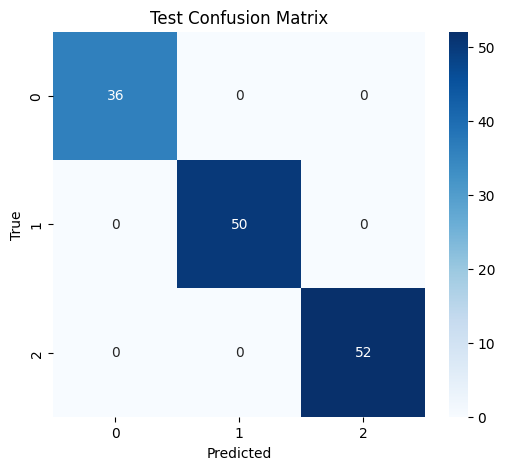

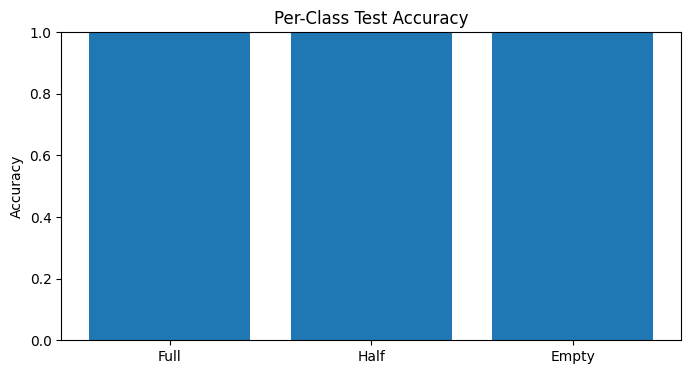

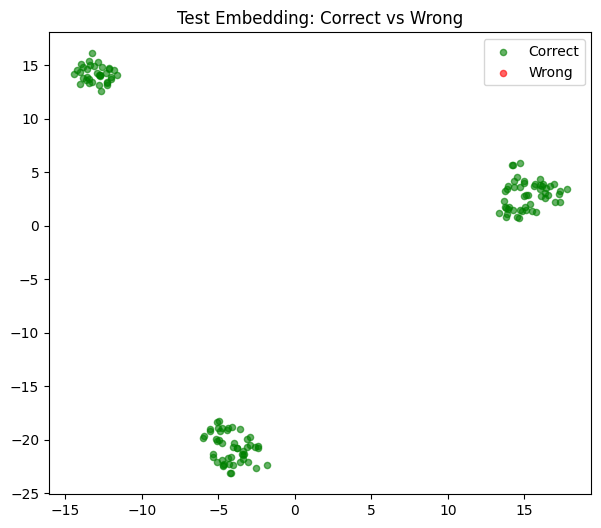

In [ ]:
# MAIN
if __name__ == "__main__":
    prepare_dataset_from_videos(RAW_VIDEOS)

    model, test_loader, criterion = train()

    if model is None:
        raise RuntimeError("Training failed or dataset was empty.")
      

    test_loss, test_acc, test_n = test(model, test_loader, criterion, DEVICE)
    
    visualize_test_correctness(model, test_loader)


    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), os.path.join("models", "multimodal_model_battery_v3.pth"))
    print("Training complete and model saved!")
    
    y_true, y_pred = collect_preds_from_loader(model, test_loader, DEVICE)

    plot_confusion_matrix(y_true, y_pred, LABELS)  
    plot_class_accuracy(y_true, y_pred, LABELS)
    visualize_test_correctness(model, test_loader)


